# Anime Generation
## DCGAN 

> Data pre-processing [here](https://www.tensorflow.org/tutorials/load_data/images)

In [1]:
import time
import os

# trainlets < version 5.0.0
# os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
# os.environ['WANDB_NOTEBOOK_NAME'] = 'Anime Faces and Names'
# os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# trainlets > version 5.0.0 required for tensorflow 2.2.1 and python 3.9
os.environ.get('TF_GPU_ALLOCATOR', 'cuda_malloc_async')
# os.environ.get('WANDB_NOTEBOOK_NAME', "Anime Faces and Names")
os.environ.get('TF_CPP_MIN_LOG_LEVEL', '2')

import winsound
from IPython import display
the_voice = "./sounds/chose_a_voice.wav"
the_creation = "./sounds/You_created_me.wav"

import tensorflow as tf
# Error: Node: 'sequential_3/dropout_4/dropout/random_uniform/RandomUniform'
# OOM when allocating tensor with shape[256,180,120,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
# 	 [[{{node sequential_3/dropout_4/dropout/random_uniform/RandomUniform}}]]
# the solution to thi is report_tensor_allocations_upon_oom = True
# Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. 
# This isn't available when running in Eager mode.
# In this project we are running in eager mode!
# you can check this by running the following code: tf.executing_eagerly()
# run_opts = tf.compat.v1.RunOptions(report_tensor_allocations_upon_oom=True)
# print("run_opts : => ", run_opts)

# runmeta = tf.compat.v1.RunMetadata()
# physical_devices = tf.config.list_physical_devices("GPU")
# print("physical_devices : => ", physical_devices)
# tf.config.experimental.set_memory_growth(physical_devices[0], True)
# tf.distribute.MultiWorkerMirroredStrategy(
#     cluster_resolver=None, communication_options=None
# )

from tensorflow import keras
from tensorflow.keras import layers, preprocessing
from tensorflow.keras.optimizers import Adam
import glob
import matplotlib.pyplot as plt
import numpy as np
import imageio
import tensorflow_docs
import PIL

print("Note! You will need tensorflow-gpu version 2.8.0 or higher. Your version is", tf.__version__)

winsound.PlaySound(sound=the_voice, flags=winsound.SND_ALIAS)

Note! You will need tensorflow-gpu version 2.8.0 or higher. Your version is 2.9.1


> Configuration

In [2]:
# BATCH_SIZE = 254 # or 64 this cause memory allocation failure
BATCH_SIZE = 64
BUFFER_SIZE = 2000
IMAGE_WIDTH = 240
IMAGE_LENGTH = 360
ORIGINAL_IMAGE_SIZE = (360, 240)
EPOCHS = 1000
CURRENT_EPOCH = 0
noise_dim = 100
num_examples_to_generate = 9
learning_rate=0.0002
# data_directory= "./dataset_faces/"
data_directory= "./dataset/"
anim_file = "anime_faces_dcgan.gif"
# folder = './anime_faces/'
folder = "./anime_tut/"
new_images_root = folder + "generated_images/"
training_checkpoints_root = folder + "training_checkpoints/"

# Load Dataset

Found 58085 files belonging to 1 classes.
Using 34851 files for training.
(64, 360, 240, 3)
CPU times: total: 3.98 s
Wall time: 2.83 s


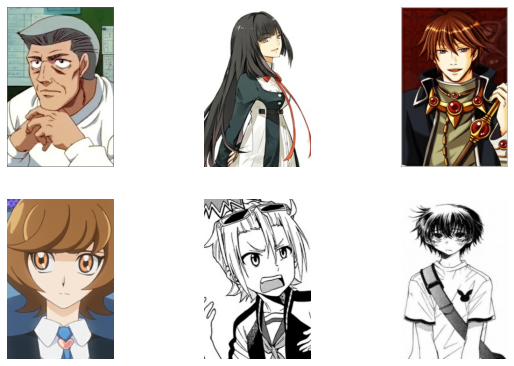

In [3]:
%%time

x_train = preprocessing.image_dataset_from_directory( 
  directory= data_directory, 
  validation_split=0.4,
  subset='training',
  label_mode=None, 
  batch_size=BATCH_SIZE, 
  image_size=ORIGINAL_IMAGE_SIZE, 
  seed=123 , 
shuffle=True)

plt.figure(figsize=(10, 10))
plt.title("Training Images")
for images in x_train.take(1):
  print(images.shape)
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")


> Cashe Dataset

In [4]:
%%time
print("Wall time: 5min 22s")
global genereator_loss_list, discriminator_loss_list 
genereator_loss_list, discriminator_loss_list = [], []

# Cache keeps the images in memory after they're loaded off disk during the first epoch. 
# This will ensure the dataset does not become a bottleneck while training your model. 
# Prefetch overlaps data preprocessing and model execution while training.
# This allows later elements to be prepared while the current element is being processed. 
# This often improves latency and throughput, at the cost of using additional memory to store prefetched elements.
def configure_for_performance(ds, name):
    ds = ds.cache(name)
    # ds = ds.shuffle(buffer_size=2000) # we are making shuffle at the loading
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

# normalized_ds = x_train.map(tf.keras.layers.Rescaling(scale=1./255)) # scale 0 to 1
normalized_ds = x_train.map(tf.keras.layers.Rescaling(scale=1./127.5, offset=-1)) # scale -1 to 1 because we are using tanh
# Cashe, shuffle and prefetch the data
train_ds = configure_for_performance(normalized_ds, "./cache/training_cashe")

for image_batch in train_ds:
    print(image_batch.shape)
    print("In range between: ", np.min(image_batch[0])," and: ", np.max(image_batch[0]))
    break


Wall time: 5min 22s
(64, 360, 240, 3)
In range between:  -0.9526961  and:  0.93099487
CPU times: total: 125 ms
Wall time: 159 ms


## DCGAN 
> Generator

In [5]:
def generator_model():
    print("Generating DCGAN model.")
    model = tf.keras.Sequential()
    model.add(layers.Dense(45*30*256, use_bias=False, input_shape=(100,)))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Reshape((45, 30, 256)))
    assert model.output_shape == (None, 45, 30, 256)  # Note: None is the batch size
    
    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 45, 30, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 90, 60, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    
    # Add another Conv2DTranspose to convert the image to the original dimensions
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 90, 60, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 180, 120, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 360, 240, 3)

    print("DCGAN model completed")
    return model

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

Generating DCGAN model.
DCGAN model completed
(64, 360, 240, 3)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 345600)            34560000  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 345600)            0         
                                                                 
 reshape (Reshape)           (None, 45, 30, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 45, 30, 256)      1638400   
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 45, 30, 256)      1024      
 ormalization)                                                   
                                                          

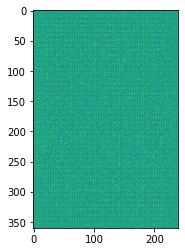

In [6]:
%%time
noise = tf.random.normal([BATCH_SIZE, noise_dim])
generator = generator_model()
generated_image = generator(noise, training=False)
print(generated_image.shape)
plt.imshow(generated_image[0, :, :, 0]) # default RGB
generator.summary()

> Discriminator 

In [7]:
def discriminator_model():
    print("DCGAN descriminator model")
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                    input_shape=[360, 240, 3]))
    
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(128, (5, 5), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(5, 5)))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(1))
    
    print("DCGAN descriminator Completed!!")
    return model

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [8]:
discriminator = discriminator_model()
decision = discriminator(generated_image)
# print(decision)
discriminator.summary()

DCGAN descriminator model
DCGAN descriminator Completed!!
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 120, 64)      4864      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 180, 120, 64)      0         
                                                                 
 batch_normalization_4 (Batc  (None, 180, 120, 64)     256       
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 60, 128)       204928    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 90, 60, 128)       0         
                                                                 
 batch_normalization_5 (Batc  (None, 90, 60, 128)      512    

### Save and plot images

### Optimizer and Checkpoint 

In [9]:
def read_images(folder):
    filenames = glob.glob(new_images_root + folder + 'image*.png')
    return sorted(filenames)

In [10]:
def generate_and_save_images(model, epoch, test_input):
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    # predictions = ((predictions + 1) /2)*255
    
    for i in range(predictions.shape[0]):
        img = tf.keras.preprocessing.image.array_to_img(
                (predictions[i] + 1) * 127.5, scale=False
                )
        name = 'image_at_epoch_{:04d}.png'.format(i)
        img.save(os.path.join(new_images_root + 'steps', name))
    
    file_images = read_images('steps/')
    fig = plt.figure(figsize=(10, 10))
    i=0
    for imgs in file_images:
        image = imageio.imread(imgs)
        plt.subplot(3, 3, i+1)
        plt.imshow(image)
        plt.axis('off')
        i+=1
    plt.savefig(new_images_root + 'image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()
    

In [11]:
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

generator_optimizer = Adam(learning_rate)
discriminator_optimizer = Adam(learning_rate)

checkpoint_dir = training_checkpoints_root
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
    # step=tf.Variable(CURRENT_EPOCH),
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator)

# manager = tf.train.CheckpointManager(checkpoint, checkpoint_prefix, max_to_keep=4)

> Save Checkpoints

In [12]:
def save_image_and_checkpoint(manager, generator, epoch):
    if manager.latest_checkpoint:
        print("Restored from {}".format(manager.latest_checkpoint))
    else:
        print("Initializing from scratch.")
    
    generate_and_save_images(generator, epoch + 1, seed)

    checkpoint.step.assign_add(1)
    save_path = manager.save()
    print("Saved checkpoint for step {}: {}".format(int(checkpoint.step), save_path))


## Training DCGAN

### Training definitions 

In [13]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        generated_images = generator(noise, training=True)
        real_out = discriminator(images, training=True)
        fake_out = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_out)
        
        disc_loss = discriminator_loss(real_output=real_out, fake_output=fake_out)
        
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        
        return gen_loss, disc_loss, generated_image


In [14]:
def train(dataset, epochs):
    print("Training Start...")
    
    for epoch in range(CURRENT_EPOCH, epochs):
        print("Epoch :", epoch, "/", EPOCHS)
        start = time.time()
        start_step_time = start

        for step, image_batch in enumerate(dataset):
            gen_loss, disc_loss, generated_image = train_step(image_batch)
            if step % 100 == 0:
                print('step: %d - gen_loss: %.3f - disc_loss: %.3f - %.3f s' % (step, gen_loss, disc_loss, time.time()-start_step_time))
                start_step_time = time.time()
        
        genereator_loss_list.append(gen_loss.numpy())
        discriminator_loss_list.append(disc_loss.numpy())
        
        display.clear_output(wait=True)
        # Save the model and image every 5 epochs
        if (epoch + 1) % 5 == 0:
            # save_image_and_checkpoint(manager, generator, epoch)
            checkpoint.save(file_prefix = checkpoint_prefix)
            
            # Produce images for the GIF as you go
            generate_and_save_images(generator, epoch + 1, seed)
            winsound.Beep(frequency=1000, duration=500 )

        print ('Time for epoch {} is {} sec'.format(epoch, time.time()-start))

    # Generate image after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)


### Start Training

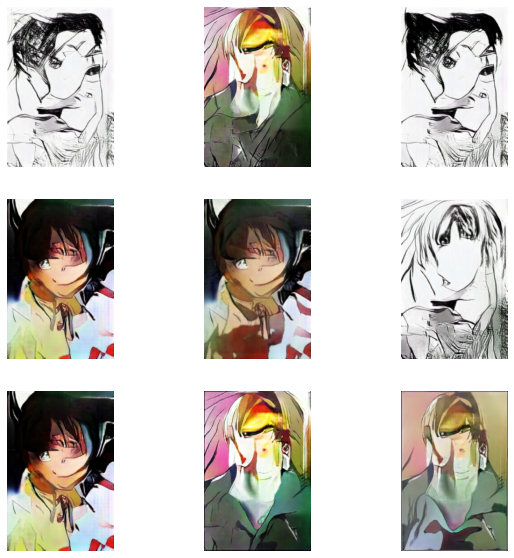

CPU times: total: 1d 22h 53min 48s
Wall time: 1d 17h 26s


In [15]:
%%time
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
train(dataset=train_ds, epochs=EPOCHS)

winsound.PlaySound(sound=the_creation, flags=winsound.SND_ALIAS)

In [16]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

 ## Create a GIF

CPU times: total: 0 ns
Wall time: 3.97 ms


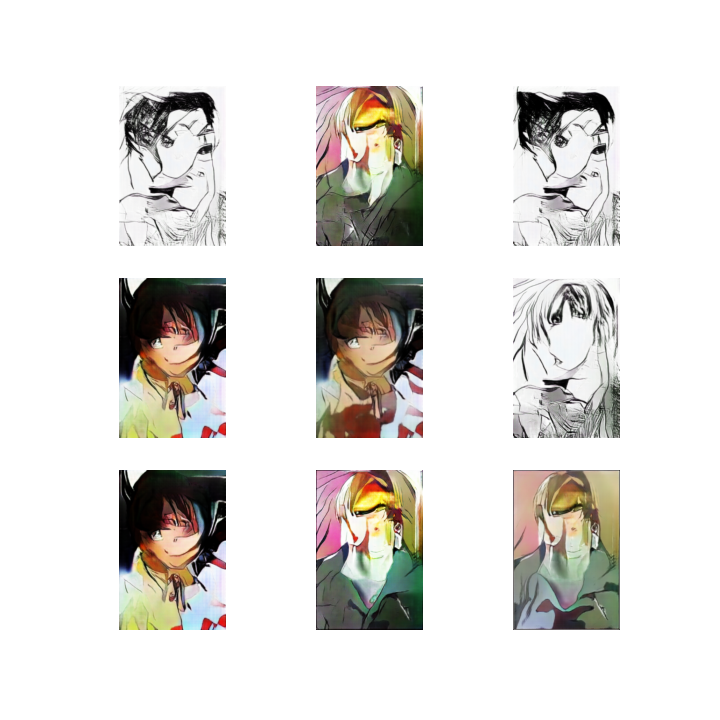

In [17]:
%%time
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open(new_images_root + 'image_at_epoch_{:04d}.png'.format(epoch_no))
display_image(EPOCHS)


In [18]:
with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = read_images('')
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
    # Added this to make the gif more "proper"
    image = imageio.imread(filename)
    writer.append_data(image)

C:\Users\Liakopoulos\AppData\Local\Temp\ipykernel_9164\2029913412.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
C:\Users\Liakopoulos\AppData\Local\Temp\ipykernel_9164\2029913412.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


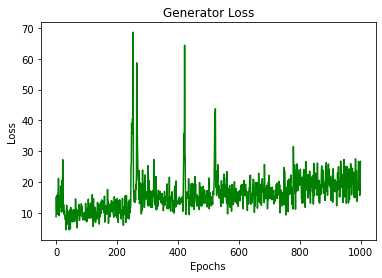

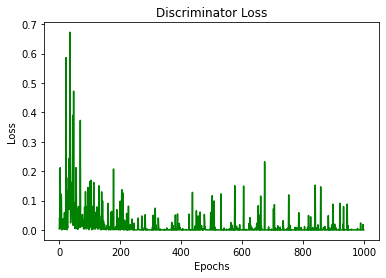

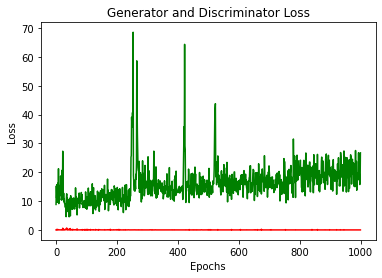

In [26]:
# PLOT
x = np.arange(0, len(genereator_loss_list) )

# plotting
plt.figure(1)
plt.title("Generator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(x, genereator_loss_list, color ="green")
plt.show()
plt.savefig(new_images_root + 'gen_loss_plot.png')
plt.close()

plt.figure(2)
plt.title("Discriminator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(x, discriminator_loss_list, color ="green")
plt.show()
plt.savefig(new_images_root + 'disc_loss_plot.png')
plt.close()

plt.figure(3)
plt.title("Generator and Discriminator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(x, genereator_loss_list, color ="green")
plt.plot(x, discriminator_loss_list, color ="red")
plt.show()
plt.savefig(new_images_root + 'loss_plot.png')
plt.close()